In [36]:
import requests
import io
import pandas as pd
from datetime import date

today = "startDate=" + date.today().strftime("%Y-%m-%d")
# today = "startDate=2022-10-13"
print(today)
ticker = input("Please specify ONE ticker to track: ") #decares stock ticker to track
token = "&token=6c67dc599e26dbdd802b077e38f2d55a559a6ad9" #api token! KEEP SAFE!

requestResponse = requests.get("https://api.tiingo.com/iex/" + ticker + "/prices?" + today + "&resampleFreq=1min" + token)
# requestResponse = requests.get("https://api.tiingo.com/iex/?tickers=aapl" + token)
data = pd.DataFrame(requestResponse.json()) #put pulled data into a pandas dataframe object
data["date"] = data["date"].str.split("T")
data["date"] = data["date"].str[1]
data["date"] = data["date"].str.split(".")
data["date"] = data["date"].str[0]
data.rename(columns={"date" : "time"}, inplace = True)

startDate=2022-10-20


In [37]:
# Class to create Candlestick object
class Candlestick():
    def __init__(self,high,open,close,low):
        if (close-open < 0): self.bullish = False
        else: self.bullish = True
        self.top = max(open, close)
        self.bottom = min(open, close)
        self.high = high
        self.low = low
        self.top_wick = high - self.top
        self.body = self.top - self.bottom
        self.bottom_wick = self.bottom - low
        self.mid = self.body/2
        if(high != low): self.body_ratio = self.body/(high - low)
        else: self.body_ratio = 0

In [38]:
#Defines buy pattern
def buyCSPattern(prev2,prev1,new):

    #3 White Soldiers
    if new.bullish and prev1.bullish and prev2.bullish: return True

    #Morning Star
    elif new.bullish and (not prev1.bullish) and (not prev2.bullish) and (prev2.body_ratio > .65) and (new.body_ratio > .75) and (prev2.bottom > prev1.mid) and (new.bottom > prev1.mid): return True
    
    #Bullish Engulfing
    elif (not prev1.bullish) and new.bullish and (prev1.bottom > new.bottom) and (prev1.top < new.top) and (new.body/prev1.body > 1): return True
    
    #Piercing Line
    elif (not prev1.bullish) and new.bullish and (new.mid < prev1.mid < new.top) and (prev1.body_ratio > .75) and (new.body_ratio > .75): return True
    
    #Hammer
    elif (new.bottom_wick/new.top_wick > 3) and new.bullish and (new.bottom_wick/new.body > 2): return True
    
    #Inverse Hammer
    elif (new.top_wick/new.bottom_wick > 3) and new.bullish and (new.top_wick/new.body > 2): return True
    
    #No matching buying pattern
    else: return False

In [39]:
#Defines sell pattern
def sellCSPattern(prev2,prev1,new):

    #3 Black Crows
    if (not new.bullish) and (not prev1.bullish) and (not prev2.bullish): return True

    #Evening Star
    elif(not new.bullish) and prev1.bullish and prev2.bullish and (prev2.body_ratio > .65) and (new.body_ratio > .6) and (prev2.mid < prev1.bottom) and (new.top < prev1.bottom): return True
    
    #Bearish Engulfing!
    elif prev1.bullish and (not new.bullish) and (prev1.bottom > new.bottom) and (prev1.top < new.top) and (new.body/prev1.body > 1): return True

    #Dark Cloud Cover
    elif (prev1.bullish ) and (not new.bullish) and (new.bottom < prev1.mid < new.mid) and (prev1.body_ratio > .75) and (new.body_ratio > .75): return True
    
    #Hangman
    elif (new.bottom_wick/new.top_wick > 3) and (not new.bullish) and (new.bottom_wick/new.body > 2): return True

    #Shooting Star
    elif (new.top_wick/new.bottom_wick > 3) and (new.bullish == False) and (new.top_wick/new.body > 2): return True
    
    #No Sell Pattern
    else: return False

In [40]:
data["asset"] = 100
data["fund"] = 100

In [41]:
log = open("trans_log/" + ticker + "_" + date.today().strftime("%Y-%m-%d") + ".txt", "w+")
total = open("price_log/" + ticker + "_" + date.today().strftime("%Y-%m-%d") + ".txt", "w+")

unit = 10 #unit of stock to buy (in dollars)
shares = [] #list to record all holdings
prev2 = Candlestick(data.iloc[0]["high"], data.iloc[0]["open"], data.iloc[0]["close"], data.iloc[0]["low"])
prev1 = Candlestick(data.iloc[1]["high"], data.iloc[1]["open"], data.iloc[1]["close"], data.iloc[1]["low"])
for i in range(2, len(data)):
    data.iat[i, len(data.columns) - 1] = data.iat[i - 1, len(data.columns) - 1]
    curr = Candlestick(data.iloc[i]["high"], data.iloc[i]["open"], data.iloc[i]["close"], data.iloc[i]["low"])
    
    if(shares and sellCSPattern(prev2, prev1, curr)):
        for x in shares:
            if x < data.iloc[i]["low"]:
                data.iat[i, len(data.columns) - 1] += unit * data.iloc[i]["low"] / x
                log.write(data.iloc[i]["time"] + " Available funds: " + str(data.iloc[i]["fund"]) + "\n")
                log.write("Current shares: " + " ".join(str(x) for x in shares) + "\n")
                log.write(f"Sold {x:.2f}\n")
                log.write("\n")
                shares.remove(x)

    if(data.iat[i, len(data.columns) - 1] > unit and buyCSPattern(prev2, prev1, curr)):
        log.write(data.iloc[i]["time"] + " Available funds: " + str(data.iloc[i]["fund"]) + "\n")
        log.write("Buying: " + str(data.iloc[i]["high"]) +  "\n")
        log.write("Current shares: " + " ".join(str(x) for x in shares) + "\n")
        log.write("\n")
        data.iat[i, len(data.columns) - 1] -= unit
        shares.append(data.iloc[i]["high"])
    
    data.iat[i, len(data.columns) - 2] = data.iat[i, len(data.columns) - 1]
    total.write(str(data.iat[i, len(data.columns) - 2]))
    for x in shares:
        total.write(" " + str(x))
        data.iat[i, len(data.columns) - 2] += 10 * data.iloc[i]["low"] / x
    total.write("\n")
    prev2 = prev1
    prev1 = curr
log.write(f"End of day fund: {data.iat[len(data.index) - 1, len(data.columns) - 1]:.2f}\n")
total.close()
log.close()


C:\Users\Jui-Teng Hsu\AppData\Local\Temp\ipykernel_20160\3278109784.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  elif (new.bottom_wick/new.top_wick > 3) and (not new.bullish) and (new.bottom_wick/new.body > 2): return True
C:\Users\Jui-Teng Hsu\AppData\Local\Temp\ipykernel_20160\907080651.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  elif (new.top_wick/new.bottom_wick > 3) and new.bullish and (new.top_wick/new.body > 2): return True
C:\Users\Jui-Teng Hsu\AppData\Local\Temp\ipykernel_20160\3278109784.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  elif prev1.bullish and (not new.bullish) and (prev1.bottom > new.bottom) and (prev1.top < new.top) and (new.body/prev1.body > 1): return True
C:\Users\Jui-Teng Hsu\AppData\Local\Temp\ipykernel_20160\3278109784.py:17: RuntimeWarning: invalid value encountered in double_scalars
  elif (new.bottom_wick/new.top_wick > 3) and (not new.bullish) and (new.bottom_wick/new.body > 2):

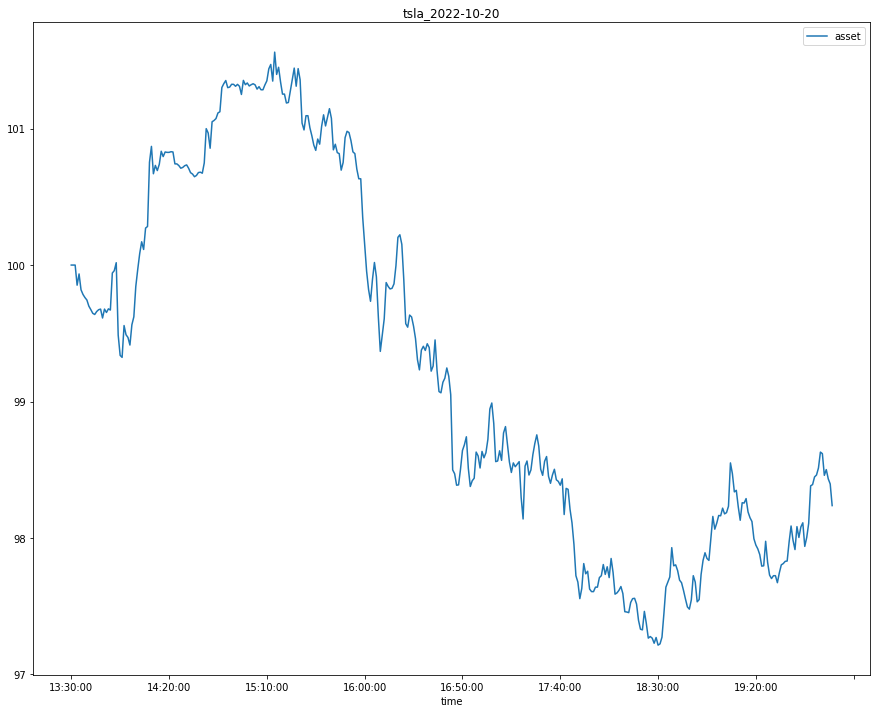

In [42]:
fig = data.plot("time", "asset", figsize = (15, 12), title = ticker + "_" + date.today().strftime("%Y-%m-%d"))
fig.figure.savefig("figs/" + ticker + "_" + date.today().strftime("%Y-%m-%d") + ".png")